# ANTIMICROBIAL RESISTANCE (AMR) GENE SIMULATION

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kruskal

In [78]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Parameters
n_otus = 300
n_samples = 60
environments = ["Soil", "Water", "Animal", "Human"]

# Assign environments
metadata = pd.DataFrame({
    "SampleID": [f"S{i+1}" for i in range(n_samples)],
    "Environment": np.repeat(environments, n_samples // len(environments))
}).set_index("SampleID")

# Simulate OTU abundances
otu_data = {}

for sample in metadata.index:
    env = metadata.loc[sample, "Environment"]
    
    if env == "Soil":
        counts = np.random.negative_binomial(5, 0.3, n_otus)
    elif env == "Water":
        counts = np.random.negative_binomial(3, 0.4, n_otus)
    elif env == "Animal":
        counts = np.random.negative_binomial(4, 0.35, n_otus)
    else:  # Human
        counts = np.random.negative_binomial(6, 0.25, n_otus)
    
    otu_data[sample] = counts

otu_table = pd.DataFrame(otu_data, index=[f"OTU_{i+1}" for i in range(n_otus)])

otu_table.shape, metadata.shape


((300, 60), (60, 1))

In [79]:
# Remove OTUs with very low abundance
otu_table = otu_table.loc[otu_table.sum(axis=1) > 10]

# Relative abundance normalization
otu_rel = otu_table.div(otu_table.sum(axis=0), axis=1)


In [80]:
import numpy as np
import pandas as pd

phyla = [
    "Proteobacteria",
    "Firmicutes",
    "Bacteroidota",
    "Actinobacteriota",
    "Acidobacteriota",
    "Cyanobacteria"
]

genera = {
    "Proteobacteria": ["Pseudomonas", "Escherichia", "Rhizobium"],
    "Firmicutes": ["Bacillus", "Clostridium", "Lactobacillus"],
    "Bacteroidota": ["Bacteroides", "Prevotella"],
    "Actinobacteriota": ["Streptomyces", "Corynebacterium"],
    "Acidobacteriota": ["Acidobacterium"],
    "Cyanobacteria": ["Synechococcus"]
}


In [81]:
taxonomy = []

for otu in otu_table.index:
    phylum = np.random.choice(phyla, p=[0.25, 0.25, 0.2, 0.15, 0.1, 0.05])
    genus = np.random.choice(genera[phylum])
    
    taxonomy.append({
        "OTU": otu,
        "Phylum": phylum,
        "Genus": genus
    })

taxonomy_df = pd.DataFrame(taxonomy).set_index("OTU")
taxonomy_df.head()


,Phylum,Genus
OTU,,
OTU_1,Firmicutes,Clostridium
OTU_2,Cyanobacteria,Synechococcus
OTU_3,Actinobacteriota,Corynebacterium
OTU_4,Proteobacteria,Escherichia
OTU_5,Firmicutes,Bacillus


In [82]:
amr_genes = [
    "blaTEM",     # beta-lactam
    "tetM",       # tetracycline
    "ermB",       # macrolide
    "sul1",       # sulfonamide
    "vanA",       # vancomycin
    "mcr-1"       # colistin
]


### ASSIGN AMR GENES TO OTUs

In [83]:
amr_assignment = {}

for otu in otu_table.index:
    phylum = taxonomy_df.loc[otu, "Phylum"]
    
    if phylum in ["Proteobacteria", "Firmicutes"]:
        genes = np.random.choice(amr_genes, size=np.random.randint(0, 3), replace=False)
    else:
        genes = np.random.choice(amr_genes, size=np.random.randint(0, 1), replace=False)
    
    amr_assignment[otu] = list(genes)


### CALCULATE AMR LOAD PER SAMPLE

In [89]:
amr_counts = pd.DataFrame(0, index=metadata.index, columns=amr_genes)

for sample in otu_table.columns:
    for otu, count in otu_table[sample].items():
        for gene in amr_assignment[otu]:
            amr_counts.loc[sample, gene] += count


### NORMALIZE & MERGE METADATA

In [85]:
amr_rel = amr_counts.div(amr_counts.sum(axis=1), axis=0)
amr_rel = amr_rel.join(metadata)
amr_rel.head()

,blaTEM,tetM,ermB,sul1,vanA,mcr-1,Environment
SampleID,,,,,,,
S1,0.106200,0.233272,0.184776,0.178637,0.125844,0.171271,Soil
S2,0.126531,0.202332,0.197085,0.163265,0.116035,0.194752,Soil
S3,0.115126,0.175138,0.232088,0.162890,0.116963,0.197795,Soil
S4,0.129944,0.177652,0.222222,0.165725,0.133710,0.170747,Soil
S5,0.148334,0.153363,0.203646,0.157134,0.157762,0.179761,Soil


### VISUALIZE AMR PROFILES

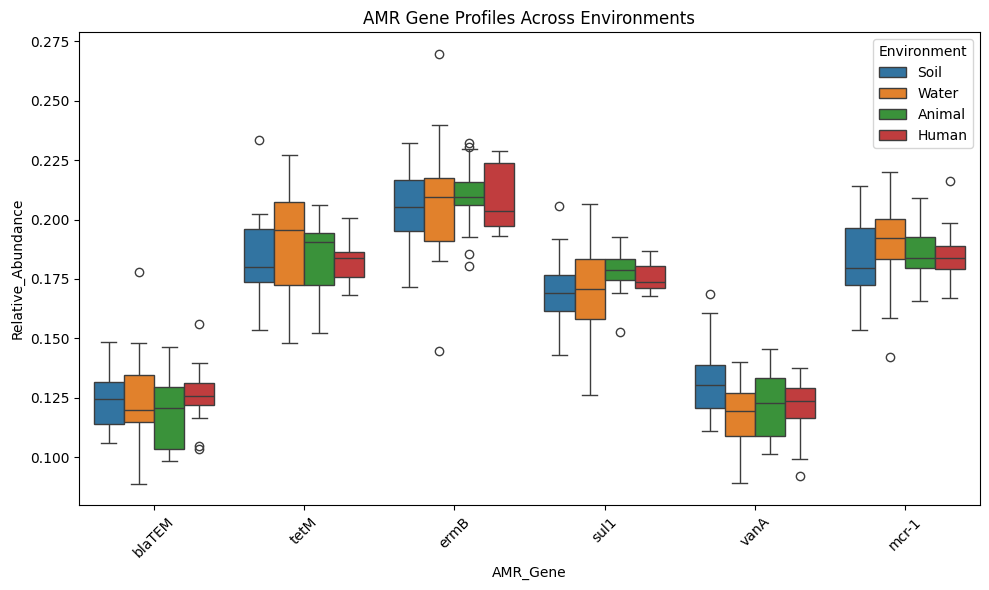

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=amr_rel.melt(
        id_vars="Environment",
        value_vars=amr_genes,
        var_name="AMR_Gene",
        value_name="Relative_Abundance"
    ),
    x="AMR_Gene",
    y="Relative_Abundance",
    hue="Environment"
)
plt.xticks(rotation=45)
plt.title("AMR Gene Profiles Across Environments")
plt.tight_layout()
plt.show()


### INTERPRETATION
Human- and animal-associated environments show elevated abundance of beta-lactam and tetracycline resistance genes, consistent with antibiotic exposure. Environmental samples display lower and more diverse AMR profiles.